<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:01:57] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


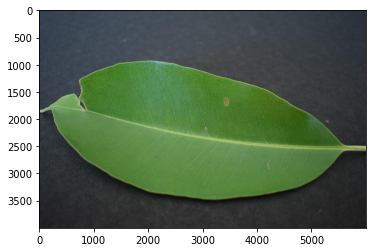

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

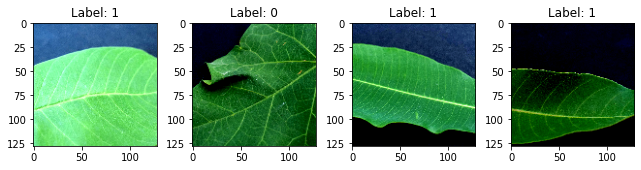

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:02:03] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:02:05] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2664230926413138 samples/sec                   batch loss = 0.40216773748397827 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.2735018101072857 samples/sec                   batch loss = 0.8483060598373413 | accuracy = 0.525


Epoch[1] Batch[15] Speed: 1.2746194899171732 samples/sec                   batch loss = 0.6922770738601685 | accuracy = 0.5833333333333334


Epoch[1] Batch[20] Speed: 1.2753041075027158 samples/sec                   batch loss = 0.9453217387199402 | accuracy = 0.55


Epoch[1] Batch[25] Speed: 1.2716190070221236 samples/sec                   batch loss = 1.306862711906433 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2826479469907854 samples/sec                   batch loss = 1.3197686672210693 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2701446342777014 samples/sec                   batch loss = 0.6119058728218079 | accuracy = 0.5857142857142857


Epoch[1] Batch[40] Speed: 1.273468557451274 samples/sec                   batch loss = 0.6775811910629272 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.2791759215178453 samples/sec                   batch loss = 0.23547708988189697 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2765398477393735 samples/sec                   batch loss = 0.5617212653160095 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2720122691460516 samples/sec                   batch loss = 0.46234947443008423 | accuracy = 0.6


Epoch[1] Batch[60] Speed: 1.2708462073944011 samples/sec                   batch loss = 0.3207467198371887 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.2689651959178527 samples/sec                   batch loss = 0.36573565006256104 | accuracy = 0.6230769230769231


Epoch[1] Batch[70] Speed: 1.2740732730404798 samples/sec                   batch loss = 0.46254539489746094 | accuracy = 0.6357142857142857


Epoch[1] Batch[75] Speed: 1.2650690923025567 samples/sec                   batch loss = 0.8906444311141968 | accuracy = 0.64


Epoch[1] Batch[80] Speed: 1.269260018150858 samples/sec                   batch loss = 0.6383962035179138 | accuracy = 0.65


Epoch[1] Batch[85] Speed: 1.2728677955999568 samples/sec                   batch loss = 0.5313519835472107 | accuracy = 0.6558823529411765


Epoch[1] Batch[90] Speed: 1.2699833973968893 samples/sec                   batch loss = 0.8255660533905029 | accuracy = 0.6527777777777778


Epoch[1] Batch[95] Speed: 1.2704999421440388 samples/sec                   batch loss = 0.9874676465988159 | accuracy = 0.6578947368421053


Epoch[1] Batch[100] Speed: 1.26883170215775 samples/sec                   batch loss = 1.3468867540359497 | accuracy = 0.655


Epoch[1] Batch[105] Speed: 1.2733595318541848 samples/sec                   batch loss = 0.9023252725601196 | accuracy = 0.65


Epoch[1] Batch[110] Speed: 1.2760959284415812 samples/sec                   batch loss = 0.3134753704071045 | accuracy = 0.6590909090909091


Epoch[1] Batch[115] Speed: 1.2779803402124663 samples/sec                   batch loss = 0.34325629472732544 | accuracy = 0.6565217391304348


Epoch[1] Batch[120] Speed: 1.27215839438192 samples/sec                   batch loss = 0.5422359108924866 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.2630719906381649 samples/sec                   batch loss = 0.6515576839447021 | accuracy = 0.652


Epoch[1] Batch[130] Speed: 1.2628438150956105 samples/sec                   batch loss = 0.7879589796066284 | accuracy = 0.65


Epoch[1] Batch[135] Speed: 1.2623478178299876 samples/sec                   batch loss = 0.32942646741867065 | accuracy = 0.6537037037037037


Epoch[1] Batch[140] Speed: 1.2638123221056587 samples/sec                   batch loss = 0.6055594682693481 | accuracy = 0.6464285714285715


Epoch[1] Batch[145] Speed: 1.2737369481983616 samples/sec                   batch loss = 0.32874029874801636 | accuracy = 0.6517241379310345


Epoch[1] Batch[150] Speed: 1.2673974825973995 samples/sec                   batch loss = 0.498214453458786 | accuracy = 0.6516666666666666


Epoch[1] Batch[155] Speed: 1.2633597043820028 samples/sec                   batch loss = 0.1903662085533142 | accuracy = 0.6564516129032258


Epoch[1] Batch[160] Speed: 1.2749385507592197 samples/sec                   batch loss = 0.5923696160316467 | accuracy = 0.65625


Epoch[1] Batch[165] Speed: 1.2708382174922566 samples/sec                   batch loss = 0.7126890420913696 | accuracy = 0.656060606060606


Epoch[1] Batch[170] Speed: 1.2757037266615072 samples/sec                   batch loss = 0.6714301705360413 | accuracy = 0.6544117647058824


Epoch[1] Batch[175] Speed: 1.2779793667300328 samples/sec                   batch loss = 0.6093454957008362 | accuracy = 0.6514285714285715


Epoch[1] Batch[180] Speed: 1.2725521832973399 samples/sec                   batch loss = 0.27475306391716003 | accuracy = 0.6513888888888889


Epoch[1] Batch[185] Speed: 1.274108492468906 samples/sec                   batch loss = 0.7247354984283447 | accuracy = 0.6472972972972973


Epoch[1] Batch[190] Speed: 1.2661194583460211 samples/sec                   batch loss = 0.49866846203804016 | accuracy = 0.6447368421052632


Epoch[1] Batch[195] Speed: 1.2683869896635767 samples/sec                   batch loss = 0.576829195022583 | accuracy = 0.6474358974358975


Epoch[1] Batch[200] Speed: 1.2705933709005677 samples/sec                   batch loss = 0.5853114128112793 | accuracy = 0.65375


Epoch[1] Batch[205] Speed: 1.277472092158941 samples/sec                   batch loss = 0.8206033110618591 | accuracy = 0.6524390243902439


Epoch[1] Batch[210] Speed: 1.2733935520224702 samples/sec                   batch loss = 1.548067569732666 | accuracy = 0.6511904761904762


Epoch[1] Batch[215] Speed: 1.2788598056267888 samples/sec                   batch loss = 0.3679840564727783 | accuracy = 0.65


Epoch[1] Batch[220] Speed: 1.2728171944107831 samples/sec                   batch loss = 0.8219243288040161 | accuracy = 0.6488636363636363


Epoch[1] Batch[225] Speed: 1.273796326560517 samples/sec                   batch loss = 0.4581299424171448 | accuracy = 0.6488888888888888


Epoch[1] Batch[230] Speed: 1.2669955863779754 samples/sec                   batch loss = 0.751869797706604 | accuracy = 0.6467391304347826


Epoch[1] Batch[235] Speed: 1.2757919073843424 samples/sec                   batch loss = 0.9423402547836304 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.2784716512829626 samples/sec                   batch loss = 0.5604517459869385 | accuracy = 0.6520833333333333


Epoch[1] Batch[245] Speed: 1.2734100795216405 samples/sec                   batch loss = 0.3350917398929596 | accuracy = 0.6551020408163265


Epoch[1] Batch[250] Speed: 1.2769123489389593 samples/sec                   batch loss = 0.7288907170295715 | accuracy = 0.655


Epoch[1] Batch[255] Speed: 1.280976819099953 samples/sec                   batch loss = 0.28192296624183655 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.2764923534321924 samples/sec                   batch loss = 0.3425646126270294 | accuracy = 0.6596153846153846


Epoch[1] Batch[265] Speed: 1.2747723169853 samples/sec                   batch loss = 0.6249098777770996 | accuracy = 0.659433962264151


Epoch[1] Batch[270] Speed: 1.275218902032191 samples/sec                   batch loss = 0.6150044798851013 | accuracy = 0.6583333333333333


Epoch[1] Batch[275] Speed: 1.2824307792877674 samples/sec                   batch loss = 0.42644840478897095 | accuracy = 0.6572727272727272


Epoch[1] Batch[280] Speed: 1.2784338522060492 samples/sec                   batch loss = 0.6461483836174011 | accuracy = 0.6580357142857143


Epoch[1] Batch[285] Speed: 1.275362856471948 samples/sec                   batch loss = 0.39348679780960083 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2712071091514672 samples/sec                   batch loss = 0.3855801522731781 | accuracy = 0.6577586206896552


Epoch[1] Batch[295] Speed: 1.2721720923295237 samples/sec                   batch loss = 0.5676297545433044 | accuracy = 0.6584745762711864


Epoch[1] Batch[300] Speed: 1.271023840197155 samples/sec                   batch loss = 0.37388867139816284 | accuracy = 0.6591666666666667


Epoch[1] Batch[305] Speed: 1.2708903943300096 samples/sec                   batch loss = 0.8787985444068909 | accuracy = 0.6549180327868852


Epoch[1] Batch[310] Speed: 1.2684462538638082 samples/sec                   batch loss = 0.37205255031585693 | accuracy = 0.6556451612903226


Epoch[1] Batch[315] Speed: 1.2764084457483182 samples/sec                   batch loss = 0.5290451049804688 | accuracy = 0.6571428571428571


Epoch[1] Batch[320] Speed: 1.269779145888684 samples/sec                   batch loss = 0.7101149559020996 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.2734605345414038 samples/sec                   batch loss = 0.7974464297294617 | accuracy = 0.6615384615384615


Epoch[1] Batch[330] Speed: 1.267808160432305 samples/sec                   batch loss = 0.3284817039966583 | accuracy = 0.6643939393939394


Epoch[1] Batch[335] Speed: 1.2768672563758443 samples/sec                   batch loss = 0.3038366734981537 | accuracy = 0.664179104477612


Epoch[1] Batch[340] Speed: 1.2707567839792029 samples/sec                   batch loss = 0.9993046522140503 | accuracy = 0.663235294117647


Epoch[1] Batch[345] Speed: 1.2662785686413474 samples/sec                   batch loss = 0.13317586481571198 | accuracy = 0.6652173913043479


Epoch[1] Batch[350] Speed: 1.2753955294453923 samples/sec                   batch loss = 0.5249841213226318 | accuracy = 0.6664285714285715


Epoch[1] Batch[355] Speed: 1.27384139591843 samples/sec                   batch loss = 0.2536141872406006 | accuracy = 0.6676056338028169


Epoch[1] Batch[360] Speed: 1.276699256309619 samples/sec                   batch loss = 0.5206267833709717 | accuracy = 0.6673611111111111


Epoch[1] Batch[365] Speed: 1.2691843554862676 samples/sec                   batch loss = 0.6552204489707947 | accuracy = 0.6657534246575343


Epoch[1] Batch[370] Speed: 1.2720042645749972 samples/sec                   batch loss = 1.2968770265579224 | accuracy = 0.6635135135135135


Epoch[1] Batch[375] Speed: 1.2742536480234246 samples/sec                   batch loss = 0.5508597493171692 | accuracy = 0.664


Epoch[1] Batch[380] Speed: 1.274539023471211 samples/sec                   batch loss = 0.265869677066803 | accuracy = 0.6651315789473684


Epoch[1] Batch[385] Speed: 1.2773117125775784 samples/sec                   batch loss = 0.38139718770980835 | accuracy = 0.6662337662337663


Epoch[1] Batch[390] Speed: 1.2665603827549496 samples/sec                   batch loss = 0.27508100867271423 | accuracy = 0.6679487179487179


Epoch[1] Batch[395] Speed: 1.2657167488073091 samples/sec                   batch loss = 0.27651122212409973 | accuracy = 0.6689873417721519


Epoch[1] Batch[400] Speed: 1.2725095215131512 samples/sec                   batch loss = 1.33241868019104 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.2751898242727893 samples/sec                   batch loss = 0.6529543995857239 | accuracy = 0.6703703703703704


Epoch[1] Batch[410] Speed: 1.2733566324920877 samples/sec                   batch loss = 0.5934237241744995 | accuracy = 0.6707317073170732


Epoch[1] Batch[415] Speed: 1.276094763705311 samples/sec                   batch loss = 1.0774792432785034 | accuracy = 0.6728915662650602


Epoch[1] Batch[420] Speed: 1.2788572710907733 samples/sec                   batch loss = 0.6784080862998962 | accuracy = 0.6738095238095239


Epoch[1] Batch[425] Speed: 1.2735995481691056 samples/sec                   batch loss = 0.5365556478500366 | accuracy = 0.6735294117647059


Epoch[1] Batch[430] Speed: 1.2707961518330755 samples/sec                   batch loss = 0.3757900893688202 | accuracy = 0.6744186046511628


Epoch[1] Batch[435] Speed: 1.2677437828875608 samples/sec                   batch loss = 0.9534681439399719 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.2734285405688828 samples/sec                   batch loss = 0.5093285441398621 | accuracy = 0.6738636363636363


Epoch[1] Batch[445] Speed: 1.2700272359311113 samples/sec                   batch loss = 0.5912991762161255 | accuracy = 0.6741573033707865


Epoch[1] Batch[450] Speed: 1.2693701676202267 samples/sec                   batch loss = 1.1920489072799683 | accuracy = 0.675


Epoch[1] Batch[455] Speed: 1.2706965337477794 samples/sec                   batch loss = 0.36634841561317444 | accuracy = 0.6758241758241759


Epoch[1] Batch[460] Speed: 1.266288508389157 samples/sec                   batch loss = 0.6978678107261658 | accuracy = 0.6771739130434783


Epoch[1] Batch[465] Speed: 1.2667668519840838 samples/sec                   batch loss = 0.49530357122421265 | accuracy = 0.6779569892473118


Epoch[1] Batch[470] Speed: 1.2752486596455543 samples/sec                   batch loss = 0.873659074306488 | accuracy = 0.6781914893617021


Epoch[1] Batch[475] Speed: 1.2726016050487734 samples/sec                   batch loss = 0.5184809565544128 | accuracy = 0.6789473684210526


Epoch[1] Batch[480] Speed: 1.2768600651839441 samples/sec                   batch loss = 1.2590934038162231 | accuracy = 0.6776041666666667


Epoch[1] Batch[485] Speed: 1.2751151974263633 samples/sec                   batch loss = 0.5213812589645386 | accuracy = 0.6778350515463918


Epoch[1] Batch[490] Speed: 1.2792580475099815 samples/sec                   batch loss = 0.639145016670227 | accuracy = 0.6790816326530612


Epoch[1] Batch[495] Speed: 1.2762533815296555 samples/sec                   batch loss = 0.2368834912776947 | accuracy = 0.6808080808080809


Epoch[1] Batch[500] Speed: 1.2746406975675242 samples/sec                   batch loss = 0.5601679682731628 | accuracy = 0.6805


Epoch[1] Batch[505] Speed: 1.276759979976351 samples/sec                   batch loss = 0.26045799255371094 | accuracy = 0.6821782178217822


Epoch[1] Batch[510] Speed: 1.276510903957734 samples/sec                   batch loss = 1.3539471626281738 | accuracy = 0.6833333333333333


Epoch[1] Batch[515] Speed: 1.2809179429808364 samples/sec                   batch loss = 0.8279505968093872 | accuracy = 0.6844660194174758


Epoch[1] Batch[520] Speed: 1.2780007836861649 samples/sec                   batch loss = 0.9390697479248047 | accuracy = 0.6841346153846154


Epoch[1] Batch[525] Speed: 1.2831672906000353 samples/sec                   batch loss = 0.5338814854621887 | accuracy = 0.6847619047619048


Epoch[1] Batch[530] Speed: 1.2752489504434164 samples/sec                   batch loss = 0.6252869963645935 | accuracy = 0.6858490566037736


Epoch[1] Batch[535] Speed: 1.2753850583992188 samples/sec                   batch loss = 0.9572091698646545 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.2797907568670681 samples/sec                   batch loss = 0.5326951742172241 | accuracy = 0.6847222222222222


Epoch[1] Batch[545] Speed: 1.279899519607111 samples/sec                   batch loss = 1.061180830001831 | accuracy = 0.6853211009174311


Epoch[1] Batch[550] Speed: 1.277211751019008 samples/sec                   batch loss = 0.654907763004303 | accuracy = 0.6854545454545454


Epoch[1] Batch[555] Speed: 1.2819517018287654 samples/sec                   batch loss = 0.49504804611206055 | accuracy = 0.6851351351351351


Epoch[1] Batch[560] Speed: 1.2770624212645625 samples/sec                   batch loss = 0.32290124893188477 | accuracy = 0.6866071428571429


Epoch[1] Batch[565] Speed: 1.2776636472856033 samples/sec                   batch loss = 0.2859801650047302 | accuracy = 0.6876106194690266


Epoch[1] Batch[570] Speed: 1.277684761751072 samples/sec                   batch loss = 0.32796531915664673 | accuracy = 0.6872807017543859


Epoch[1] Batch[575] Speed: 1.2789048440574875 samples/sec                   batch loss = 0.6658039093017578 | accuracy = 0.6882608695652174


Epoch[1] Batch[580] Speed: 1.2809228328178635 samples/sec                   batch loss = 0.5303158164024353 | accuracy = 0.6875


Epoch[1] Batch[585] Speed: 1.2786166334168636 samples/sec                   batch loss = 0.3657643795013428 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.271287155421549 samples/sec                   batch loss = 0.47939547896385193 | accuracy = 0.6894067796610169


Epoch[1] Batch[595] Speed: 1.275723515333806 samples/sec                   batch loss = 0.6553054451942444 | accuracy = 0.6882352941176471


Epoch[1] Batch[600] Speed: 1.2729040107530438 samples/sec                   batch loss = 0.8398573398590088 | accuracy = 0.68875


Epoch[1] Batch[605] Speed: 1.2797456560185296 samples/sec                   batch loss = 0.7757225632667542 | accuracy = 0.6896694214876034


Epoch[1] Batch[610] Speed: 1.2682806540364362 samples/sec                   batch loss = 0.37796175479888916 | accuracy = 0.6901639344262295


Epoch[1] Batch[615] Speed: 1.2730548811089648 samples/sec                   batch loss = 0.6599940061569214 | accuracy = 0.6902439024390243


Epoch[1] Batch[620] Speed: 1.2771487482702724 samples/sec                   batch loss = 0.6438265442848206 | accuracy = 0.6903225806451613


Epoch[1] Batch[625] Speed: 1.2693843818475754 samples/sec                   batch loss = 0.38645491003990173 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.268502550392972 samples/sec                   batch loss = 0.2435396909713745 | accuracy = 0.6916666666666667


Epoch[1] Batch[635] Speed: 1.2658956249031368 samples/sec                   batch loss = 0.4392516016960144 | accuracy = 0.6929133858267716


Epoch[1] Batch[640] Speed: 1.2723622541688533 samples/sec                   batch loss = 0.42667156457901 | accuracy = 0.69375


Epoch[1] Batch[645] Speed: 1.26770469971079 samples/sec                   batch loss = 0.3027608096599579 | accuracy = 0.6945736434108527


Epoch[1] Batch[650] Speed: 1.26439817998944 samples/sec                   batch loss = 0.31751564145088196 | accuracy = 0.695


Epoch[1] Batch[655] Speed: 1.2666627004535678 samples/sec                   batch loss = 0.14398664236068726 | accuracy = 0.6958015267175572


Epoch[1] Batch[660] Speed: 1.2758289682678796 samples/sec                   batch loss = 0.6082868576049805 | accuracy = 0.6954545454545454


Epoch[1] Batch[665] Speed: 1.2718871971801569 samples/sec                   batch loss = 0.2089618593454361 | accuracy = 0.6966165413533835


Epoch[1] Batch[670] Speed: 1.268055672497718 samples/sec                   batch loss = 0.6243945956230164 | accuracy = 0.6962686567164179


Epoch[1] Batch[675] Speed: 1.2769430603524978 samples/sec                   batch loss = 0.5066341161727905 | accuracy = 0.6962962962962963


Epoch[1] Batch[680] Speed: 1.2719863269864229 samples/sec                   batch loss = 0.24390026926994324 | accuracy = 0.6974264705882353


Epoch[1] Batch[685] Speed: 1.2705622906026404 samples/sec                   batch loss = 0.32436180114746094 | accuracy = 0.698905109489051


Epoch[1] Batch[690] Speed: 1.2725322998474375 samples/sec                   batch loss = 0.41177016496658325 | accuracy = 0.6985507246376812


Epoch[1] Batch[695] Speed: 1.2760177987626353 samples/sec                   batch loss = 0.5525402426719666 | accuracy = 0.6967625899280575


Epoch[1] Batch[700] Speed: 1.2747241792848325 samples/sec                   batch loss = 0.5258264541625977 | accuracy = 0.6971428571428572


Epoch[1] Batch[705] Speed: 1.2744381400689526 samples/sec                   batch loss = 0.16400502622127533 | accuracy = 0.6968085106382979


Epoch[1] Batch[710] Speed: 1.273901944754051 samples/sec                   batch loss = 0.16132470965385437 | accuracy = 0.6975352112676056


Epoch[1] Batch[715] Speed: 1.2726172431992808 samples/sec                   batch loss = 0.5612505674362183 | accuracy = 0.6961538461538461


Epoch[1] Batch[720] Speed: 1.2760764193895098 samples/sec                   batch loss = 0.3664141297340393 | accuracy = 0.6965277777777777


Epoch[1] Batch[725] Speed: 1.2764216527077676 samples/sec                   batch loss = 0.8008221387863159 | accuracy = 0.6958620689655173


Epoch[1] Batch[730] Speed: 1.2729705554327646 samples/sec                   batch loss = 0.7329161763191223 | accuracy = 0.6955479452054795


Epoch[1] Batch[735] Speed: 1.277275732393281 samples/sec                   batch loss = 0.24003008008003235 | accuracy = 0.6948979591836735


Epoch[1] Batch[740] Speed: 1.2355530090855464 samples/sec                   batch loss = 0.5165293216705322 | accuracy = 0.6956081081081081


Epoch[1] Batch[745] Speed: 1.2789791351538102 samples/sec                   batch loss = 0.5810019969940186 | accuracy = 0.6959731543624161


Epoch[1] Batch[750] Speed: 1.2687438093101926 samples/sec                   batch loss = 0.4950343668460846 | accuracy = 0.696


Epoch[1] Batch[755] Speed: 1.276036529602571 samples/sec                   batch loss = 0.6686480045318604 | accuracy = 0.6956953642384106


Epoch[1] Batch[760] Speed: 1.2779408180178424 samples/sec                   batch loss = 0.726922333240509 | accuracy = 0.6950657894736842


Epoch[1] Batch[765] Speed: 1.2707824834998098 samples/sec                   batch loss = 0.9088782668113708 | accuracy = 0.6950980392156862


Epoch[1] Batch[770] Speed: 1.2693018861415233 samples/sec                   batch loss = 0.6061124801635742 | accuracy = 0.6957792207792208


Epoch[1] Batch[775] Speed: 1.2719195958839675 samples/sec                   batch loss = 0.5342841148376465 | accuracy = 0.6954838709677419


Epoch[1] Batch[780] Speed: 1.2809180407772112 samples/sec                   batch loss = 0.3918089270591736 | accuracy = 0.6958333333333333


Epoch[1] Batch[785] Speed: 1.269115325975832 samples/sec                   batch loss = 0.3399437367916107 | accuracy = 0.695859872611465


[Epoch 1] training: accuracy=0.6963832487309645
[Epoch 1] time cost: 647.2630019187927
[Epoch 1] validation: validation accuracy=0.7233333333333334


Epoch[2] Batch[5] Speed: 1.2677096807659929 samples/sec                   batch loss = 0.29150328040122986 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2732215368603779 samples/sec                   batch loss = 0.4319869875907898 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2761923177360759 samples/sec                   batch loss = 0.1714729368686676 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2760819517466666 samples/sec                   batch loss = 0.3450068533420563 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2739588233440438 samples/sec                   batch loss = 0.19816595315933228 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2757953029254323 samples/sec                   batch loss = 0.2809900641441345 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.276063801912299 samples/sec                   batch loss = 0.371578574180603 | accuracy = 0.7857142857142857


Epoch[2] Batch[40] Speed: 1.2817868659679388 samples/sec                   batch loss = 0.4183879792690277 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.2739595972374333 samples/sec                   batch loss = 0.0594961978495121 | accuracy = 0.7611111111111111


Epoch[2] Batch[50] Speed: 1.279038223211062 samples/sec                   batch loss = 0.5168189406394958 | accuracy = 0.745


Epoch[2] Batch[55] Speed: 1.274760693867543 samples/sec                   batch loss = 0.778685450553894 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.274388865978661 samples/sec                   batch loss = 0.46013009548187256 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2725207175416584 samples/sec                   batch loss = 0.2251611053943634 | accuracy = 0.7461538461538462


Epoch[2] Batch[70] Speed: 1.2735196937944553 samples/sec                   batch loss = 0.3252759873867035 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2783912822106336 samples/sec                   batch loss = 0.10238470882177353 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2761622248522186 samples/sec                   batch loss = 0.25111761689186096 | accuracy = 0.753125


Epoch[2] Batch[85] Speed: 1.2760901047814923 samples/sec                   batch loss = 0.41109535098075867 | accuracy = 0.7470588235294118


Epoch[2] Batch[90] Speed: 1.2671747284336843 samples/sec                   batch loss = 0.16618463397026062 | accuracy = 0.75


Epoch[2] Batch[95] Speed: 1.2604495307539867 samples/sec                   batch loss = 0.4972260892391205 | accuracy = 0.7526315789473684


Epoch[2] Batch[100] Speed: 1.2648764312985372 samples/sec                   batch loss = 0.6089835166931152 | accuracy = 0.755


Epoch[2] Batch[105] Speed: 1.267339082226261 samples/sec                   batch loss = 0.5543285608291626 | accuracy = 0.7547619047619047


Epoch[2] Batch[110] Speed: 1.2694564182994588 samples/sec                   batch loss = 0.4280913472175598 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.274700450770277 samples/sec                   batch loss = 0.3909597098827362 | accuracy = 0.7565217391304347


Epoch[2] Batch[120] Speed: 1.2791279382891425 samples/sec                   batch loss = 0.46036863327026367 | accuracy = 0.7604166666666666


Epoch[2] Batch[125] Speed: 1.2704455846696745 samples/sec                   batch loss = 0.3214741051197052 | accuracy = 0.762


Epoch[2] Batch[130] Speed: 1.2775584745613642 samples/sec                   batch loss = 1.322664499282837 | accuracy = 0.7596153846153846


Epoch[2] Batch[135] Speed: 1.2695120360328838 samples/sec                   batch loss = 0.4272300601005554 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2777472335190283 samples/sec                   batch loss = 0.6882510185241699 | accuracy = 0.7517857142857143


Epoch[2] Batch[145] Speed: 1.2729098053687773 samples/sec                   batch loss = 0.9650222659111023 | accuracy = 0.7517241379310344


Epoch[2] Batch[150] Speed: 1.2785068220190836 samples/sec                   batch loss = 0.5272594690322876 | accuracy = 0.7533333333333333


Epoch[2] Batch[155] Speed: 1.2761240768813593 samples/sec                   batch loss = 0.42627325654029846 | accuracy = 0.7532258064516129


Epoch[2] Batch[160] Speed: 1.2768170169046509 samples/sec                   batch loss = 0.3871636688709259 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2743582773012574 samples/sec                   batch loss = 0.4707815647125244 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.2728333206888705 samples/sec                   batch loss = 0.7649549841880798 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2767272370576552 samples/sec                   batch loss = 0.489926815032959 | accuracy = 0.7528571428571429


Epoch[2] Batch[180] Speed: 1.2699709001235286 samples/sec                   batch loss = 0.10863402485847473 | accuracy = 0.7555555555555555


Epoch[2] Batch[185] Speed: 1.2748193927798144 samples/sec                   batch loss = 1.859964370727539 | accuracy = 0.7513513513513513


Epoch[2] Batch[190] Speed: 1.2687142585554494 samples/sec                   batch loss = 0.617232620716095 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.276647961456792 samples/sec                   batch loss = 0.5122633576393127 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2748448694024606 samples/sec                   batch loss = 0.36262768507003784 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2759371556755619 samples/sec                   batch loss = 0.1755201518535614 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.272372965126266 samples/sec                   batch loss = 0.7631420493125916 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2712938023160179 samples/sec                   batch loss = 0.42557913064956665 | accuracy = 0.7488372093023256


Epoch[2] Batch[220] Speed: 1.2756620172551654 samples/sec                   batch loss = 0.7087851762771606 | accuracy = 0.7465909090909091


Epoch[2] Batch[225] Speed: 1.2774887256998915 samples/sec                   batch loss = 0.5505573749542236 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.2627808911805032 samples/sec                   batch loss = 0.3059803545475006 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.2650840689080016 samples/sec                   batch loss = 0.4961049258708954 | accuracy = 0.7468085106382979


Epoch[2] Batch[240] Speed: 1.27656733583439 samples/sec                   batch loss = 0.7170107364654541 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.2720187307407493 samples/sec                   batch loss = 0.36200588941574097 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2775298736885918 samples/sec                   batch loss = 0.1588512659072876 | accuracy = 0.752


Epoch[2] Batch[255] Speed: 1.2631651860285504 samples/sec                   batch loss = 0.46255412697792053 | accuracy = 0.7519607843137255


Epoch[2] Batch[260] Speed: 1.2620144265114548 samples/sec                   batch loss = 1.8017346858978271 | accuracy = 0.7509615384615385


Epoch[2] Batch[265] Speed: 1.262334900503528 samples/sec                   batch loss = 0.6995136141777039 | accuracy = 0.7509433962264151


Epoch[2] Batch[270] Speed: 1.262045754568698 samples/sec                   batch loss = 0.9450493454933167 | accuracy = 0.7537037037037037


Epoch[2] Batch[275] Speed: 1.2547265532304361 samples/sec                   batch loss = 0.4425676465034485 | accuracy = 0.7536363636363637


Epoch[2] Batch[280] Speed: 1.2610233647476463 samples/sec                   batch loss = 0.8731041550636292 | accuracy = 0.7553571428571428


Epoch[2] Batch[285] Speed: 1.2656032226186795 samples/sec                   batch loss = 0.7542091012001038 | accuracy = 0.7578947368421053


Epoch[2] Batch[290] Speed: 1.270080788422572 samples/sec                   batch loss = 0.21880394220352173 | accuracy = 0.7603448275862069


Epoch[2] Batch[295] Speed: 1.2673712496337195 samples/sec                   batch loss = 0.6168348789215088 | accuracy = 0.7584745762711864


Epoch[2] Batch[300] Speed: 1.2657516032370595 samples/sec                   batch loss = 0.48530393838882446 | accuracy = 0.7575


Epoch[2] Batch[305] Speed: 1.2691039977887602 samples/sec                   batch loss = 0.5096843838691711 | accuracy = 0.7573770491803279


Epoch[2] Batch[310] Speed: 1.262627599794424 samples/sec                   batch loss = 0.447000116109848 | accuracy = 0.7548387096774194


Epoch[2] Batch[315] Speed: 1.2780451774812207 samples/sec                   batch loss = 1.163124442100525 | accuracy = 0.7523809523809524


Epoch[2] Batch[320] Speed: 1.2677117881472855 samples/sec                   batch loss = 0.32114356756210327 | accuracy = 0.75390625


Epoch[2] Batch[325] Speed: 1.275377108275287 samples/sec                   batch loss = 0.24587146937847137 | accuracy = 0.7553846153846154


Epoch[2] Batch[330] Speed: 1.2720116904989827 samples/sec                   batch loss = 0.20018549263477325 | accuracy = 0.7568181818181818


Epoch[2] Batch[335] Speed: 1.270468096758489 samples/sec                   batch loss = 0.322252094745636 | accuracy = 0.7582089552238805


Epoch[2] Batch[340] Speed: 1.2689325636487003 samples/sec                   batch loss = 0.4324032664299011 | accuracy = 0.7573529411764706


Epoch[2] Batch[345] Speed: 1.277691086496372 samples/sec                   batch loss = 0.9803404211997986 | accuracy = 0.7565217391304347


Epoch[2] Batch[350] Speed: 1.2756999436028809 samples/sec                   batch loss = 0.3145141005516052 | accuracy = 0.7564285714285715


Epoch[2] Batch[355] Speed: 1.2682268697658063 samples/sec                   batch loss = 0.3032959997653961 | accuracy = 0.7591549295774648


Epoch[2] Batch[360] Speed: 1.2700804999769486 samples/sec                   batch loss = 0.28404998779296875 | accuracy = 0.7611111111111111


Epoch[2] Batch[365] Speed: 1.2732517811027795 samples/sec                   batch loss = 0.3229576349258423 | accuracy = 0.7616438356164383


Epoch[2] Batch[370] Speed: 1.2674250571021386 samples/sec                   batch loss = 0.30171841382980347 | accuracy = 0.7621621621621621


Epoch[2] Batch[375] Speed: 1.268031712401987 samples/sec                   batch loss = 0.702166736125946 | accuracy = 0.7613333333333333


Epoch[2] Batch[380] Speed: 1.2672337836838556 samples/sec                   batch loss = 1.4739995002746582 | accuracy = 0.7625


Epoch[2] Batch[385] Speed: 1.2681063750455117 samples/sec                   batch loss = 0.4959271550178528 | accuracy = 0.762987012987013


Epoch[2] Batch[390] Speed: 1.2672719763145484 samples/sec                   batch loss = 0.7711858749389648 | accuracy = 0.7647435897435897


Epoch[2] Batch[395] Speed: 1.26804120049161 samples/sec                   batch loss = 0.3854493498802185 | accuracy = 0.7639240506329114


Epoch[2] Batch[400] Speed: 1.2684678320109617 samples/sec                   batch loss = 0.17028076946735382 | accuracy = 0.765


Epoch[2] Batch[405] Speed: 1.2687965819391396 samples/sec                   batch loss = 0.3607551157474518 | accuracy = 0.7648148148148148


Epoch[2] Batch[410] Speed: 1.2655826965080943 samples/sec                   batch loss = 0.600645124912262 | accuracy = 0.7652439024390244


Epoch[2] Batch[415] Speed: 1.264299752968489 samples/sec                   batch loss = 0.19674548506736755 | accuracy = 0.7650602409638554


Epoch[2] Batch[420] Speed: 1.267977565921023 samples/sec                   batch loss = 0.5024595856666565 | accuracy = 0.7636904761904761


Epoch[2] Batch[425] Speed: 1.2655202630365503 samples/sec                   batch loss = 0.2551417946815491 | accuracy = 0.7635294117647059


Epoch[2] Batch[430] Speed: 1.270249551572172 samples/sec                   batch loss = 0.2726038098335266 | accuracy = 0.7633720930232558


Epoch[2] Batch[435] Speed: 1.2631055584135322 samples/sec                   batch loss = 0.42433294653892517 | accuracy = 0.7626436781609195


Epoch[2] Batch[440] Speed: 1.2667353847482705 samples/sec                   batch loss = 0.2887282371520996 | accuracy = 0.7625


Epoch[2] Batch[445] Speed: 1.2622608209427417 samples/sec                   batch loss = 0.214560404419899 | accuracy = 0.7617977528089888


Epoch[2] Batch[450] Speed: 1.2648656554606708 samples/sec                   batch loss = 0.29398566484451294 | accuracy = 0.7627777777777778


Epoch[2] Batch[455] Speed: 1.2687806537376782 samples/sec                   batch loss = 0.39698660373687744 | accuracy = 0.762087912087912


Epoch[2] Batch[460] Speed: 1.268164942013778 samples/sec                   batch loss = 0.3983019292354584 | accuracy = 0.7619565217391304


Epoch[2] Batch[465] Speed: 1.2609095417088354 samples/sec                   batch loss = 0.41808879375457764 | accuracy = 0.7602150537634409


Epoch[2] Batch[470] Speed: 1.2643194752580302 samples/sec                   batch loss = 0.3084259331226349 | accuracy = 0.7611702127659574


Epoch[2] Batch[475] Speed: 1.2669239246029502 samples/sec                   batch loss = 0.21075791120529175 | accuracy = 0.7631578947368421


Epoch[2] Batch[480] Speed: 1.2711457568015878 samples/sec                   batch loss = 0.4234068691730499 | accuracy = 0.7635416666666667


Epoch[2] Batch[485] Speed: 1.2637799543140804 samples/sec                   batch loss = 1.0247607231140137 | accuracy = 0.7618556701030927


Epoch[2] Batch[490] Speed: 1.2687593527920815 samples/sec                   batch loss = 0.5125430226325989 | accuracy = 0.761734693877551


Epoch[2] Batch[495] Speed: 1.2725987091371518 samples/sec                   batch loss = 0.5334072709083557 | accuracy = 0.7636363636363637


Epoch[2] Batch[500] Speed: 1.2736646185200764 samples/sec                   batch loss = 0.28754377365112305 | accuracy = 0.764


Epoch[2] Batch[505] Speed: 1.2679986489567847 samples/sec                   batch loss = 0.8564652800559998 | accuracy = 0.7643564356435644


Epoch[2] Batch[510] Speed: 1.267554615888374 samples/sec                   batch loss = 0.594465434551239 | accuracy = 0.7642156862745098


Epoch[2] Batch[515] Speed: 1.2674434407719 samples/sec                   batch loss = 0.23194874823093414 | accuracy = 0.7645631067961165


Epoch[2] Batch[520] Speed: 1.2654264334878647 samples/sec                   batch loss = 0.2997140884399414 | accuracy = 0.7644230769230769


Epoch[2] Batch[525] Speed: 1.267090127261731 samples/sec                   batch loss = 0.36241260170936584 | accuracy = 0.7647619047619048


Epoch[2] Batch[530] Speed: 1.2636659186601895 samples/sec                   batch loss = 0.1390887349843979 | accuracy = 0.7646226415094339


Epoch[2] Batch[535] Speed: 1.2649204901739404 samples/sec                   batch loss = 0.8119044899940491 | accuracy = 0.7654205607476635


Epoch[2] Batch[540] Speed: 1.2643492980528879 samples/sec                   batch loss = 0.15661132335662842 | accuracy = 0.7657407407407407


Epoch[2] Batch[545] Speed: 1.2644603121941485 samples/sec                   batch loss = 0.5591769814491272 | accuracy = 0.7651376146788991


Epoch[2] Batch[550] Speed: 1.2678100765308533 samples/sec                   batch loss = 0.3745141923427582 | accuracy = 0.7654545454545455


Epoch[2] Batch[555] Speed: 1.2657999251560255 samples/sec                   batch loss = 0.24478258192539215 | accuracy = 0.7648648648648648


Epoch[2] Batch[560] Speed: 1.2680692822353166 samples/sec                   batch loss = 0.7286149859428406 | accuracy = 0.7642857142857142


Epoch[2] Batch[565] Speed: 1.2680218411059168 samples/sec                   batch loss = 0.5275835990905762 | accuracy = 0.7628318584070797


Epoch[2] Batch[570] Speed: 1.2696155998234049 samples/sec                   batch loss = 0.5338771343231201 | accuracy = 0.7640350877192983


Epoch[2] Batch[575] Speed: 1.2699832051292823 samples/sec                   batch loss = 0.7565223574638367 | accuracy = 0.7639130434782608


Epoch[2] Batch[580] Speed: 1.274391092427068 samples/sec                   batch loss = 0.2549777030944824 | accuracy = 0.7633620689655173


Epoch[2] Batch[585] Speed: 1.2690405444799906 samples/sec                   batch loss = 0.15924260020256042 | accuracy = 0.7649572649572649


Epoch[2] Batch[590] Speed: 1.2737864620191863 samples/sec                   batch loss = 0.2984178364276886 | accuracy = 0.764406779661017


Epoch[2] Batch[595] Speed: 1.2705687374744339 samples/sec                   batch loss = 0.2322099357843399 | accuracy = 0.765126050420168


Epoch[2] Batch[600] Speed: 1.2645186381632947 samples/sec                   batch loss = 0.2832792103290558 | accuracy = 0.7670833333333333


Epoch[2] Batch[605] Speed: 1.2689806488426232 samples/sec                   batch loss = 0.7056757211685181 | accuracy = 0.7665289256198347


Epoch[2] Batch[610] Speed: 1.2698148010650352 samples/sec                   batch loss = 0.2005583792924881 | accuracy = 0.7663934426229508


Epoch[2] Batch[615] Speed: 1.2688670162503946 samples/sec                   batch loss = 0.41133207082748413 | accuracy = 0.767479674796748


Epoch[2] Batch[620] Speed: 1.2705542080498347 samples/sec                   batch loss = 0.14525209367275238 | accuracy = 0.7661290322580645


Epoch[2] Batch[625] Speed: 1.2741803887198855 samples/sec                   batch loss = 0.9757104516029358 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.27086969636324 samples/sec                   batch loss = 0.7177177667617798 | accuracy = 0.7642857142857142


Epoch[2] Batch[635] Speed: 1.2699197599983227 samples/sec                   batch loss = 0.70210862159729 | accuracy = 0.7645669291338583


Epoch[2] Batch[640] Speed: 1.275188176572791 samples/sec                   batch loss = 0.37212666869163513 | accuracy = 0.764453125


Epoch[2] Batch[645] Speed: 1.2781757481597271 samples/sec                   batch loss = 1.6024036407470703 | accuracy = 0.7643410852713178


Epoch[2] Batch[650] Speed: 1.2712251210914043 samples/sec                   batch loss = 0.8625029921531677 | accuracy = 0.7653846153846153


Epoch[2] Batch[655] Speed: 1.2756483410436186 samples/sec                   batch loss = 0.466176837682724 | accuracy = 0.7656488549618321


Epoch[2] Batch[660] Speed: 1.2763058097982691 samples/sec                   batch loss = 0.9617283344268799 | accuracy = 0.7643939393939394


Epoch[2] Batch[665] Speed: 1.2769503496707348 samples/sec                   batch loss = 0.535652756690979 | accuracy = 0.7646616541353384


Epoch[2] Batch[670] Speed: 1.2791100917871852 samples/sec                   batch loss = 0.7324590086936951 | accuracy = 0.764179104477612


Epoch[2] Batch[675] Speed: 1.2675299086214646 samples/sec                   batch loss = 0.47465071082115173 | accuracy = 0.7644444444444445


Epoch[2] Batch[680] Speed: 1.2707538964575757 samples/sec                   batch loss = 0.31535136699676514 | accuracy = 0.7639705882352941


Epoch[2] Batch[685] Speed: 1.2674208442529282 samples/sec                   batch loss = 0.565176784992218 | accuracy = 0.7645985401459854


Epoch[2] Batch[690] Speed: 1.2690229783465579 samples/sec                   batch loss = 0.28883352875709534 | accuracy = 0.7659420289855072


Epoch[2] Batch[695] Speed: 1.2691028457810647 samples/sec                   batch loss = 0.31860774755477905 | accuracy = 0.7658273381294964


Epoch[2] Batch[700] Speed: 1.2677705102708718 samples/sec                   batch loss = 0.5661495327949524 | accuracy = 0.7664285714285715


Epoch[2] Batch[705] Speed: 1.2730616431017596 samples/sec                   batch loss = 0.5453143119812012 | accuracy = 0.7663120567375886


Epoch[2] Batch[710] Speed: 1.26922247374683 samples/sec                   batch loss = 0.2816208600997925 | accuracy = 0.7672535211267606


Epoch[2] Batch[715] Speed: 1.2730114128704448 samples/sec                   batch loss = 0.41289812326431274 | accuracy = 0.7674825174825175


Epoch[2] Batch[720] Speed: 1.2729567437006637 samples/sec                   batch loss = 0.3859994113445282 | accuracy = 0.7680555555555556


Epoch[2] Batch[725] Speed: 1.2713080596574295 samples/sec                   batch loss = 0.7534420490264893 | accuracy = 0.7672413793103449


Epoch[2] Batch[730] Speed: 1.269711589145782 samples/sec                   batch loss = 0.417550653219223 | accuracy = 0.7678082191780822


Epoch[2] Batch[735] Speed: 1.2733443586721322 samples/sec                   batch loss = 0.7137717008590698 | accuracy = 0.7666666666666667


Epoch[2] Batch[740] Speed: 1.2742029365909735 samples/sec                   batch loss = 0.23236168920993805 | accuracy = 0.7675675675675676


Epoch[2] Batch[745] Speed: 1.2771213323484114 samples/sec                   batch loss = 0.38587939739227295 | accuracy = 0.7667785234899329


Epoch[2] Batch[750] Speed: 1.2733215512571165 samples/sec                   batch loss = 0.7078933715820312 | accuracy = 0.7663333333333333


Epoch[2] Batch[755] Speed: 1.2730398117834454 samples/sec                   batch loss = 0.38329431414604187 | accuracy = 0.7665562913907285


Epoch[2] Batch[760] Speed: 1.2696204037487715 samples/sec                   batch loss = 0.8401551246643066 | accuracy = 0.7667763157894737


Epoch[2] Batch[765] Speed: 1.2730669561464925 samples/sec                   batch loss = 0.25746074318885803 | accuracy = 0.7673202614379085


Epoch[2] Batch[770] Speed: 1.265050586668422 samples/sec                   batch loss = 0.4335591495037079 | accuracy = 0.7685064935064935


Epoch[2] Batch[775] Speed: 1.2648414343359957 samples/sec                   batch loss = 0.6444348096847534 | accuracy = 0.7683870967741936


Epoch[2] Batch[780] Speed: 1.2605088131549835 samples/sec                   batch loss = 1.0721604824066162 | accuracy = 0.7689102564102565


Epoch[2] Batch[785] Speed: 1.2634588414208243 samples/sec                   batch loss = 0.26326897740364075 | accuracy = 0.7687898089171975


[Epoch 2] training: accuracy=0.7693527918781726
[Epoch 2] time cost: 638.9400877952576
[Epoch 2] validation: validation accuracy=0.7577777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7911111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)